In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import cv2

from sklearn import preprocessing

In [2]:
INPUT_DIR = 'images'
names = sorted(os.listdir(INPUT_DIR))

images = [cv2.imread(os.path.join(INPUT_DIR, name)) for name in names]

In [3]:
def imshow(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

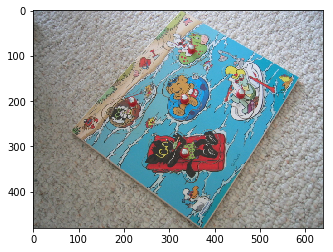

In [4]:
image = images[0]
imshow(image)
plt.show()

1) Write a program to extract the color histogram of each of the 2,000 images. Choose the
parameters required with justifications. Implement your own histogram code and compare its
results with open-source API like OpenCV and numpy.

#### Important constants

In [5]:
HUE_RANGE = 180
SATURATION_RANGE = 256
# These are number of bins both for hue and saturation channels
HISTOGRAM_SHAPE = [50, 50]

#### Calculate image histogram with OpenCV
For color image, we  pass [0], [1] or [2] to calculate histogram of blue, green or red channel respectively.
Set mask to none, no need to filter values.
Set histogram size to 256

Use implementations from this tutorial:
https://docs.opencv.org/master/dd/d0d/tutorial_py_2d_histogram.html

In [6]:
def hist_opencv(image):
    # Use hue and saturation channeks
    channels = [0, 1] 
    # No mask needed
    mask = None
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], channels, mask, HISTOGRAM_SHAPE, [0, HUE_RANGE, 0, SATURATION_RANGE])
    
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist

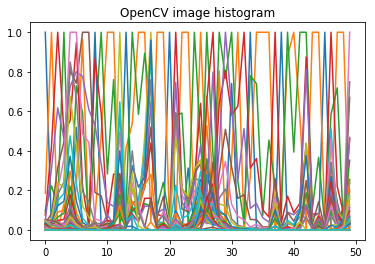

In [7]:
h1 = hist_opencv(image)

plt.plot(h1)
plt.title('OpenCV image histogram')
plt.show()

#### Numpy histogram
Numpy can calculate all image channels in one shot

In [8]:
def hist_numpy(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_range = 180
    saturation_range = 256
    hist, xbins, ybins = np.histogram2d(
        hsv[:,:,0].ravel(),hsv[:,:,1].ravel(), HISTOGRAM_SHAPE,[[0,HUE_RANGE],[0,SATURATION_RANGE]]
    )
    
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist

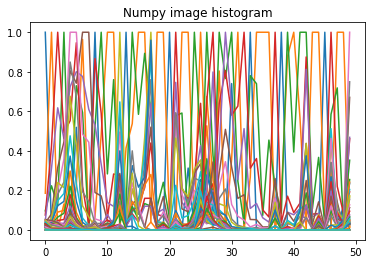

In [9]:
h2 = hist_numpy(image)
plt.plot(h2)
plt.title('Numpy image histogram')
plt.show()

In [10]:
h2.shape

(50, 50)

#### Custom histogram implementation

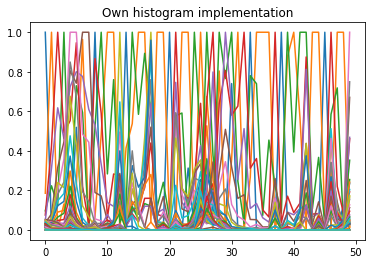

In [11]:
def calc_histogram(image):
    H, W, C = image.shape
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hue_range = 180
    saturation_range = 256
    
    hist = np.zeros(HISTOGRAM_SHAPE) 
    hist_width, hist_height = HISTOGRAM_SHAPE
    for i in range(H):
        for j in range(W):
            hue = hsv[i, j, 0]
            saturation = hsv[i, j, 1]
            hue_bin = int(hist_height * hue/ HUE_RANGE)
            saturation_bin = int(hist_width * saturation / SATURATION_RANGE)
            hist[hue_bin, saturation_bin] += 1
            
    # Scale histogram
    hist = preprocessing.normalize(hist, norm='max')
    return hist   

h3 = calc_histogram(image)
plt.plot(h3)
plt.title('Own histogram implementation')
plt.show()

In [12]:
np.sum(h3-h2), np.sum(h2-h1)

(0.0, 1.211885929336496e-09)

#### Results are nearly the same as in numpy or OpenCV
#### Calculate histogram for every image

In [13]:
histograms = [hist_opencv(im) for im in images]

2)  Write a program to measure the L​ 2 ​ distance between color histograms of two images.

In [14]:
def distance(h1, h2):
    return np.linalg.norm(np.subtract(h1, h2))

In [15]:
distance(histograms[0], histograms[1])

2.6966496

3) Use 5 images shown above (ukbench00004.jpg; ukbench00040.jpg; ukbench00060.jpg;
ukbench00588.jpg; ukbench01562.jpg) as queries. For each query image, find 10 best matches
from the 2,000 images based on the color histogram similarity.
Plot the query image and the 10 returned matches (use icons of reduced resolution to save
space).

In [16]:
test_indexes = [4, 40, 60, 588, 1562]

In [17]:
def find_top_similarities(index, histograms, top_components=10):
    # Skip the same image histogram
    distances = [distance(histograms[index], hist) for h_idx, hist in enumerate(histograms)]
    nearest_images = np.argsort(distances)
    # Delete the same image index from result
    return np.delete(nearest_images, np.where(nearest_images==index))[0:top_components]    

In [18]:
find_top_similarities(4, histograms)

array([  7,   5,   6, 136, 883, 881, 227, 882, 880,  61])

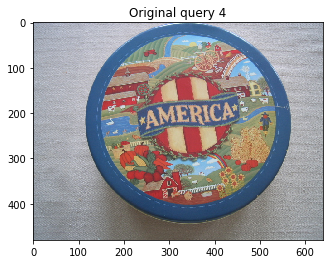

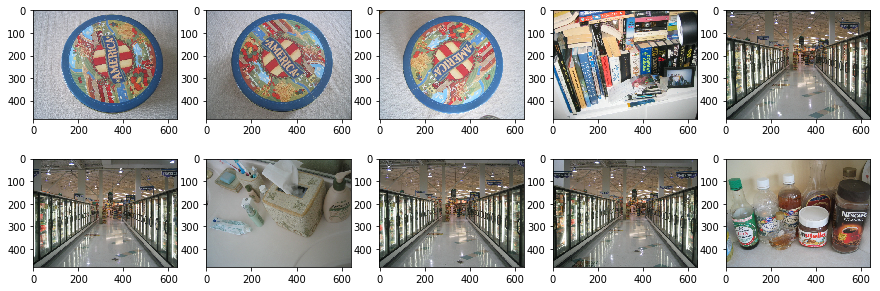

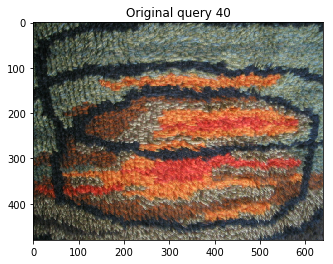

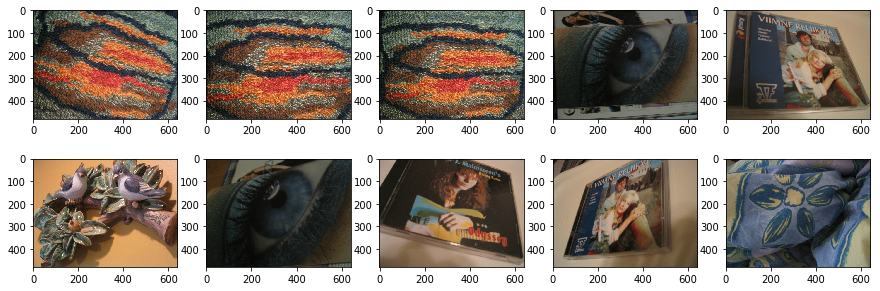

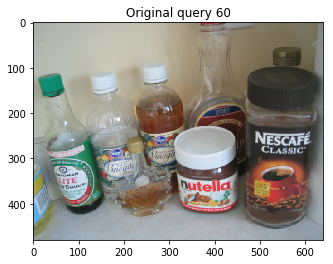

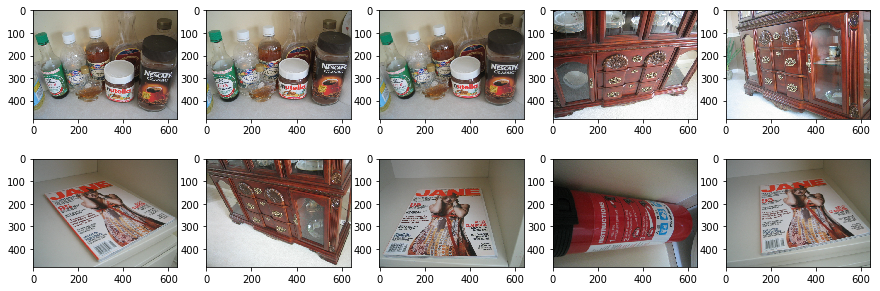

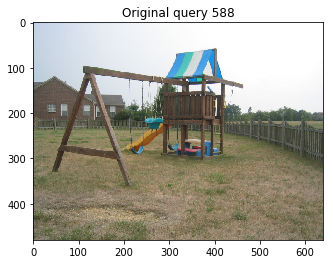

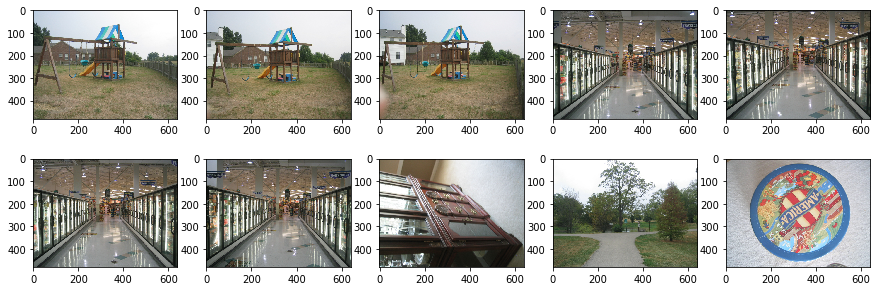

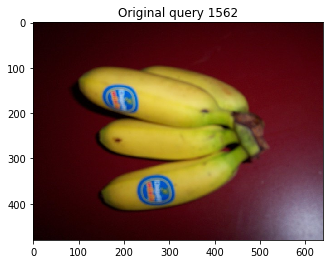

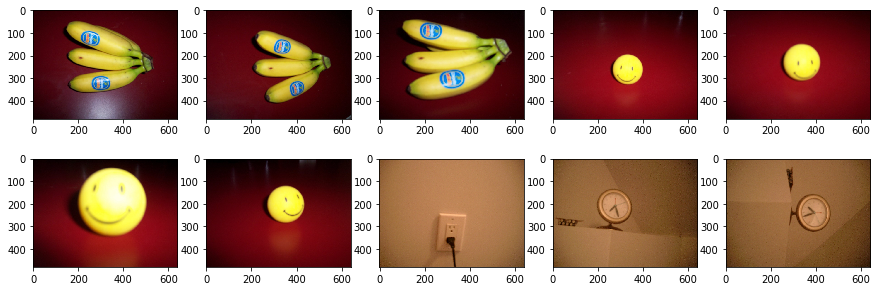

In [19]:
for index in test_indexes:
    
    plt.figure()
    imshow(images[index])
    plt.title(f'Original query {index}')
    plt.show()

    rows, columns = 2, 5
    fig, axes = plt.subplots(rows, columns)
    fig.set_size_inches(15, 5)

    for plot_index, image_index in enumerate(find_top_similarities(index, histograms)):
        axes[int(plot_index // 5), plot_index% 5 ].imshow(cv2.cvtColor(images[image_index], cv2.COLOR_BGR2RGB))
    
    
plt.show()

4) Write a program to measure and plot the P-R curve for each query.

Tutorial used: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [20]:
true = [
    np.array([1,1,1,0,0,0,0,0,0,0]),
    np.array([1,1,1,0,0,0,0,0,0,0]),
    np.array([1,1,1,0,0,0,0,0,0,0]),
    np.array([1,1,1,0,0,0,0,0,0,0]),
    np.array([1,1,1,0,0,0,0,0,0,0]),
]

In [21]:
IMAGES_PER_OBJECT = 4

def get_correct_indexes(image_index):
    start = image_index - (image_index % IMAGES_PER_OBJECT)
    return list(range(start, start + IMAGES_PER_OBJECT))

In [22]:
scores = {}
 
for idx, test_image_index in enumerate(test_indexes):
    top_ten_image_indexes = find_top_similarities(index, histograms)
    distances = np.zeros(10)
    
    for i, predicted_index in enumerate(top_ten_image_indexes):
        distances[i] = distance(histograms[test_image_index], histograms[predicted_index])
    
    distances = (distances - distances.min()) / (distances.max() - distances.min())
    scores[idx] = 1 - np.array(distances)

In [23]:
from inspect import signature
from sklearn.metrics import precision_recall_curve

def prec_rec_curve(true_values: np.array, score_values: np.array):
    
    precision, recall, _ = precision_recall_curve(true_values, score_values)
    
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

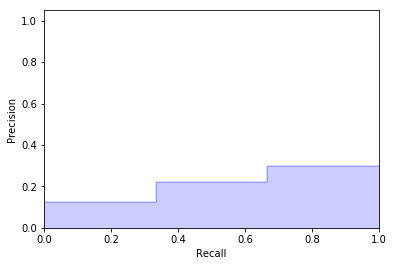

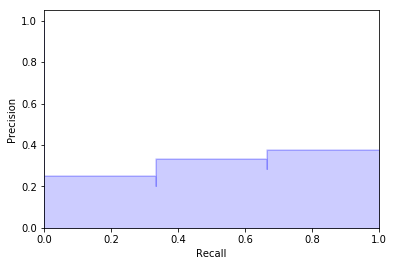

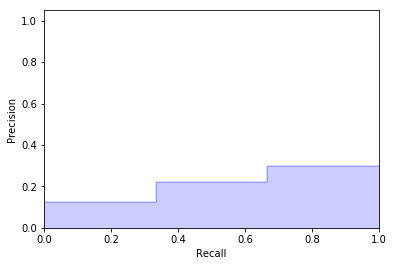

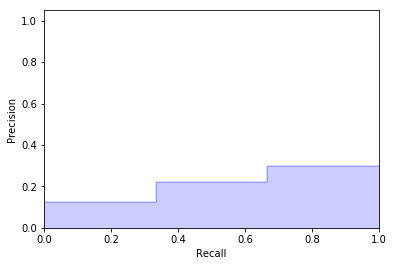

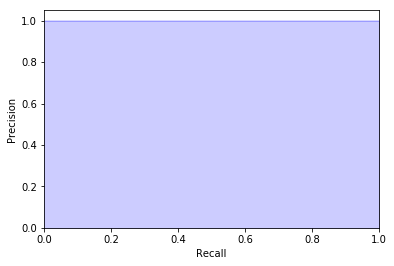

In [24]:
for t, s in zip(true, scores.values()):
    prec_rec_curve(t,s[0:])

5) Discuss and explain success and failure cases.

In [29]:
for index in test_indexes:
    top_sim = find_top_similarities(index, histograms)

    print([distance(histograms[i], histograms[index]) for i in top_sim])

[6.067919, 6.2181478, 7.549181, 9.417192, 9.476, 9.696381, 9.7003975, 9.712277, 9.795362, 9.998513]
[4.1497765, 5.2351794, 6.44467, 10.278424, 10.551466, 10.617387, 10.637629, 10.829432, 11.019453, 11.044328]
[6.7934647, 7.1674905, 7.5798516, 7.934325, 8.037545, 8.72673, 8.786941, 8.841462, 8.950348, 8.962252]
[6.4422584, 8.868846, 8.9697895, 9.636517, 9.728289, 9.763701, 9.852926, 9.977116, 10.128701, 10.182415]
[10.019152, 11.657537, 12.066763, 13.181214, 13.410122, 13.63348, 13.8005705, 14.1515465, 14.17072, 14.173419]


At first, I was calculating histogram as the sum of RGB histograms of an image. 
It gave me bad results, some images were really different.

Then converting to HSV gave me some boost, top-10 images were similar.

Only after tuning 2d histogram bins count, I received photos of the same object as top-3 images.

If using 256x256 2d histogram, then small lighting changes can make images distant in sense of l2 distance.
